In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time

import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer
import qiskit as qiskit
import qiskit.quantum_info as qi
from qiskit import QuantumCircuit, transpile, Aer, IBMQ

import ramsey_experiment

# Loading your IBM Quantum account(s)
IBMQ.save_account(
    '280beccbee94456a161a6cbc217e1366bc278bf60e22bd30281fa0ca5bec6e50897278ef818f3c53f6700e04b9ed32ea364195044413b7e02836a79d886b03d9',
    overwrite=True)
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-research')

C:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
ibmqfactory.load_account:WARNING:2023-09-14 11:47:14,490: Credentials are already in use. The existing account in the session will be replaced.


In [2]:
h = lambda n, J, z: sum([J[i] * (z[i] - 1) * (z[(i + 1) % n] - 1) for i in range(n)])


def effective_hem(size, J):
    hem = np.zeros((2 ** size, 2 ** size))
    for i in range(2 ** size):
        binary = '{0:b}'.format(i).zfill(size)
        Z = [(-1) ** int(i) for i in binary]
        hem[i, i] = h(size, J, Z)
    return hem

In [12]:
import random
import random
import importlib
import ramsey_experiment

ramsey_experiment = importlib.reload(ramsey_experiment)
RamseyExperiment = ramsey_experiment.RamseyExperiment
RamseyBatch = ramsey_experiment.RamseyBatch

exp = []
measurements = 128
#shots = np.arange(10, 2000, 100)
shots = [2 ** i for i in range(7, 12)]
delay = np.linspace(0, 2 * np.pi, measurements)
repetitions = 4
for n in range(3, 7):  #qubits
    shot_list = {}
    median_dist_for_shots = []
    mean_dist_for_shots = []
    std_dist_for_shots = []
    for s in shots:
        rep_list = []
        for rep in range(repetitions):
            J = [random.gauss(1, 0.4) for _ in range(n)]
            delay_list = []
            for t in delay:
                delay_list.append(RamseyExperiment(n, t, s // measurements, J,
                                                   f'J = {J} CosineFit n = {n} shots = {s} rep = {rep} delay = {t}'))
            ramseyBatch = RamseyBatch(delay_list)
            ramseyBatch.curve_fit(use_fft=True)
            rep_list.append(ramseyBatch)

        median_dist_for_shots.append(np.median([rep_list[i].dist for i in range(len(rep_list))]))
        mean_dist_for_shots.append(np.mean([rep_list[i].dist for i in range(len(rep_list))]))
        std_dist_for_shots.append(np.std([rep_list[i].dist for i in range(len(rep_list))]))

        shot_list["mean"] = mean_dist_for_shots
        shot_list["std"] = std_dist_for_shots
        shot_list["median"] = median_dist_for_shots

    exp.append(shot_list)


ibmqfactory.load_account:WARNING:2023-09-07 15:00:21,357: Credentials are already in use. The existing account in the session will be replaced.


5
5
5


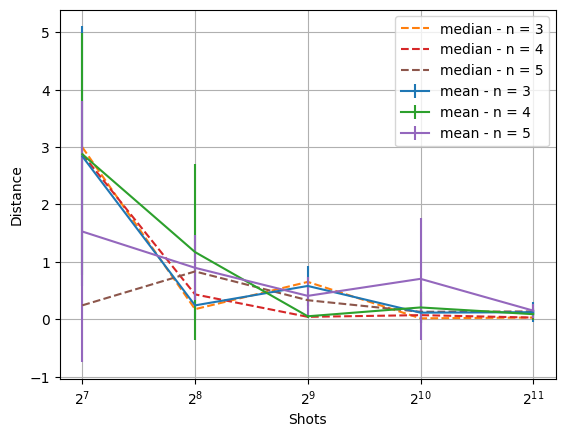

In [13]:
plt.grid()
plt.ylabel('Distance')
plt.xlabel('Shots')
#plt.ylim(0, 0.1)
for i in range(1, len(exp)):
    dist = exp[i]
    print(len(dist["mean"]))
    plt.errorbar(shots, dist["mean"], yerr=dist["std"], linestyle='-', label=f'mean - n = {str(i + 2)}')
    plt.plot(shots, dist["median"], linestyle='--', label=f'median - n = {str(i + 2)}')
    plt.title("shots divided between 128 measurements")
plt.xscale('log', base=2)
plt.legend()

## 4 Qubits with Varying Number of Measurement Points

In [14]:
import random
from ramsey_experiment import RamseyExperiment
from ramsey_experiment import RamseyBatch

exp = []
measurements = [2 ** i for i in range(7, 10)]
shots = [2 ** i for i in range(7, 12)]
#shots = [500]
repetitions = 20
for n in measurements:  #qubits
    shot_list = {}
    median_dist_for_shots = []
    mean_dist_for_shots = []
    std_dist_for_shots = []
    for s in shots:
        rep_list = []
        for rep in range(repetitions):
            J = [random.gauss(1, 0.1) for _ in range(4)]
            delay_list = []
            delay = np.linspace(0, 2 * np.pi, n)
            for t in delay:
                delay_list.append(
                    RamseyExperiment(4, t, s // n, J, f'CosineFit meas = {n} shots = {s} rep = {rep} delay = {t}'))
            ramseyBatch = RamseyBatch(delay_list)
            ramseyBatch.curve_fit(use_fft=True)
            rep_list.append(ramseyBatch)
        median_dist_for_shots.append(np.median([rep_list[i].dist for i in range(len(rep_list))]))
        mean_dist_for_shots.append(np.mean([rep_list[i].dist for i in range(len(rep_list))]))
        std_dist_for_shots.append(np.std([rep_list[i].dist for i in range(len(rep_list))]))

        shot_list["mean"] = mean_dist_for_shots
        shot_list["std"] = std_dist_for_shots
        shot_list["median"] = median_dist_for_shots

    exp.append(shot_list)



QiskitError: 'No counts for experiment "0"'

In [ ]:
plt.grid()
plt.ylabel('Distance')
plt.xlabel('Shots')
#plt.ylim(0, 0.1)
for i in range(1, len(exp)):
    dist = exp[i]
    plt.errorbar(shots, dist["mean"], yerr=dist["std"], linestyle='-',
                 label=f'mean - measurement points = {str(measurements[i])}')
    plt.plot(shots, dist["median"], linestyle='--', label=f'median - measurement points = {str(measurements[i])}')
plt.xscale('log', base=2)
plt.legend()

## 4 Qubits with Varying Number of Measurement Points and fixed number of shots

In [9]:
import random
from ramsey_experiment import RamseyExperiment
from ramsey_experiment import RamseyBatch

exp = []
measurements = [2 ** i for i in range(4, 9)]
shots = 5
repetitions = 20
shot_list = {}
median_dist_for_shots = []
mean_dist_for_shots = []
std_dist_for_shots = []
for n in measurements:  #qubits

    rep_list = []
    for rep in range(repetitions):
        J = [random.gauss(1, 0.4) for _ in range(4)]
        delay_list = []
        delay = np.linspace(0, 2 * np.pi, n)
        for t in delay:
            delay_list.append(
                RamseyExperiment(4, t, shots, J, "0"))
        ramseyBatch = RamseyBatch(delay_list)
        ramseyBatch.curve_fit(use_fft=True)
        rep_list.append(ramseyBatch)
    median_dist_for_shots.append(np.median([rep_list[i].dist for i in range(len(rep_list))]))
    mean_dist_for_shots.append(np.mean([rep_list[i].dist for i in range(len(rep_list))]))
    std_dist_for_shots.append(np.std([rep_list[i].dist for i in range(len(rep_list))]))

shot_list["mean"] = mean_dist_for_shots
shot_list["std"] = std_dist_for_shots
shot_list["median"] = median_dist_for_shots

exp.append(shot_list)



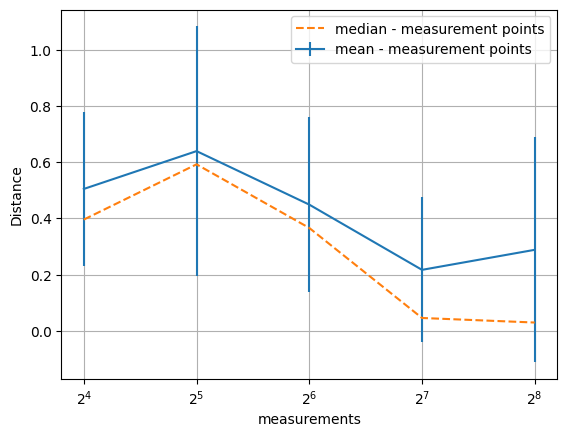

In [11]:
plt.grid()
plt.ylabel('Distance')
plt.xlabel('measurements')
#plt.ylim(0, 0.1)
dist = shot_list
plt.errorbar(measurements, dist["mean"], yerr=dist["std"], linestyle='-', label=f'mean - measurement points')
plt.plot(measurements, dist["median"], linestyle='--', label=f'median - measurement points')

plt.xscale('log', base=2)
plt.legend()

ibmqfactory.load_account:WARNING:2023-09-14 11:56:24,292: Credentials are already in use. The existing account in the session will be replaced.


J =  [1.2187600846502067, 1.2447931423989682, 1.5130410635207037, 0.21734530553350462]
FFT:  [1.21801014 1.2451901  1.51380898 0.21804692]
No FFT:  [1.03634111 1.07717315 0.94080687 0.89931025]


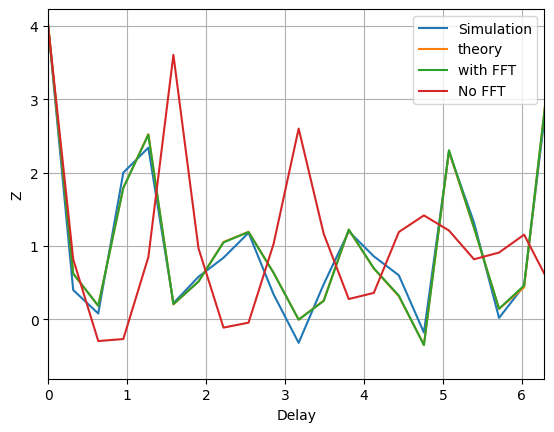

In [8]:
from scipy.optimize import curve_fit
import random
import importlib
import ramsey_experiment

ramsey_experiment = importlib.reload(ramsey_experiment)
RamseyExperiment = ramsey_experiment.RamseyExperiment
RamseyBatch = ramsey_experiment.RamseyBatch

n = 4


def func(t, js):
    n = len(js)
    result = 2 * n
    for i in range(n):
        result += 4 * np.cos(4 * js[i] * t)
    for i in range(n):
        result += 2 * np.cos(4 * (js[i] + js[(i + 1) % n]) * t)
    return result / (2 ** (n - (n - 3)))


J = [random.gauss(1, 0.4) for _ in range(n)]
shots = 5
J = [1.2187600846502067, 1.2447931423989682, 1.5130410635207037, 0.21734530553350462]
print("J = ",J)
delay_list = []
exp = []
measurements = 100
delay = np.linspace(0, 10 * np.pi, measurements)
for t in delay:
    delay_list.append(RamseyExperiment(n, t, 100, J, "0"))
ramseyBatch1 = RamseyBatch(delay_list)
ramseyBatch2 = RamseyBatch(delay_list)

ramseyBatch1.curve_fit(use_fft=True)
ramseyBatch2.curve_fit(use_fft=False)
J_fit_fft = ramseyBatch1.J_fit
J_fit_no_fft = ramseyBatch2.J_fit
print("FFT: " , J_fit_fft)
print("No FFT: ", J_fit_no_fft)
#print(ramseyBatch.Z)
plt.grid()
plt.ylabel('Z')
plt.xlabel('Delay')
#plt.title(f'J = {J}')
plt.plot(delay, ramseyBatch1.Z, label='Simulation')
plt.plot(delay, [func(t, J) for t in delay], label='theory')

plt.plot(delay, [func(t, J_fit_fft) for t in delay], label='with FFT')
plt.plot(delay, [func(t, J_fit_no_fft) for t in delay], label='No FFT')


plt.xlim(0,2*np.pi)
plt.legend()

IndexError: list index out of range

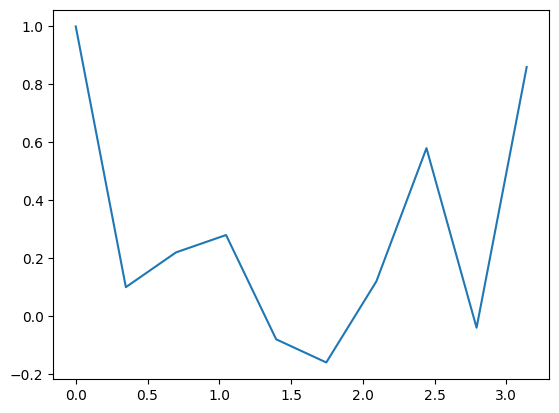

In [47]:
def func2(t, js):
    n = len(js)
    result = 2
    result += 2 * np.cos(4 * js[0] * t)
    result += 2 * np.cos(4 * js[3] * t)
    result += 2 * np.cos(4 * (js[0] + js[3]) * t)

    return result / (2 ** (n - (n - 3)))

plt.plot(delay, ramseyBatch1.get_zi(0), label='Simulation - Z0')
plt.plot(delay, [func2(t, J) for t in delay], label='theory')
plt.xlim(0,2*np.pi)

plt.legend()

In [127]:
ramsey_experiment = importlib.reload(ramsey_experiment)
RamseyExperiment = ramsey_experiment.RamseyExperiment
RamseyBatch = ramsey_experiment.RamseyBatch

ibmqfactory.load_account:WARNING:2023-09-06 11:55:53,573: Credentials are already in use. The existing account in the session will be replaced.


Frequency: 0.6207042780583918, Magnitude: 295.7959315049904
Frequency: 1.0822536130248883, Magnitude: 215.8116848922633
Frequency: 0.6525352666767709, Magnitude: 212.7608082434791
Frequency: 0.716197243913529, Magnitude: 185.655237164095


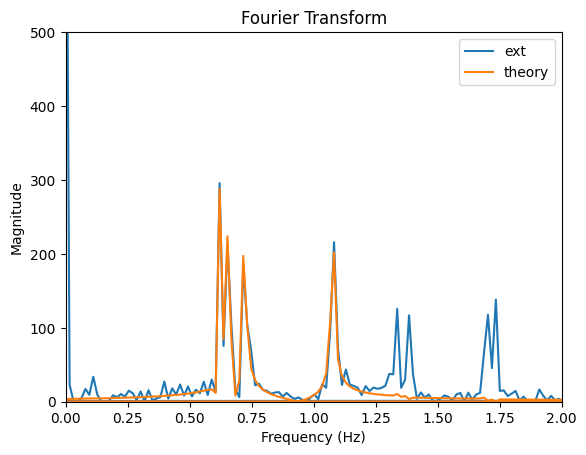

In [38]:
from scipy.signal import find_peaks
%matplotlib inline
w_ = 10*2*np.pi
def fo(w, js):
    n = len(js)
    result = 0
    for i in range(n):
        #result += (np.sqrt(2/np.pi) * np.sin(10 * np.pi * (4 * js[i] + w))) / (4 * js[i] + w)


        result += 2*(np.sqrt(2/np.pi) * np.sin(w_ * np.pi * (2 * js[i]/np.pi + w))) / (w_*(2 * js[i]/np.pi + w))
        result += 2*(np.sqrt(2/np.pi) * np.sin(w_ * np.pi * (2 * js[i]/np.pi - w))) / (2 * js[i]/np.pi - w)

        result += (np.sin(w_ * np.pi * (2 * (js[i] + js[(i + 1) % n])/np.pi + w)))/(w_*(np.sqrt(2/np.pi) * (2 * (js[i] + js[(i + 1) % n])/np.pi + w)))
        result += (np.sin(w_ * np.pi * (2 * (js[i] + js[(i + 1) % n])/np.pi - w)))/(w_*(np.sqrt(2/np.pi) * (2 * (js[i] + js[(i + 1) % n])/np.pi - w)))

    #result += (3 * np.sqrt(2/np.pi) * np.sin(10 * np.pi * w)) / w
    #result = result/ (2 ** (n - (n - 3)))
    return 2*np.pi*result/(2 ** (n - (n - 3)))

extended = ramseyBatch1.Z[::-1]
extended = extended + ramseyBatch1.Z
fft_output_ext = np.fft.fft(extended)
fft_output = np.fft.fft(ramseyBatch1.Z)

# Compute the corresponding frequencies
sample_rate = measurements / (10 * np.pi)  # Sampling rate of your data (change if known)
frequencies_ext = np.fft.fftfreq(2 * len(ramseyBatch1.Z), 1 / sample_rate)
frequencies = np.fft.fftfreq( len(ramseyBatch1.Z), 1 / sample_rate)

plt.plot(frequencies_ext, np.abs(fft_output_ext), label= "ext")
#plt.plot(frequencies, np.abs(fft_output), label= "org")


positive_indices = np.where(frequencies_ext > 0)
positive_magnitudes = np.abs(fft_output_ext)[positive_indices]
peaks, _ = find_peaks(positive_magnitudes)

# Get the magnitudes of these peaks
peak_magnitudes = positive_magnitudes[peaks]

# Sort the peaks by their magnitudes in descending order
sorted_peak_indices = np.argsort(peak_magnitudes)[::-1]

# Choose the n highest peaks
n_highest_peaks = sorted_peak_indices[:n]  # Choose a value for n

# Print the x (frequency) values of the n highest peaks
for peak_index in n_highest_peaks:
    val = frequencies_ext[positive_indices][peaks[peak_index]]
    print(f"Frequency: {frequencies_ext[positive_indices][peaks[peak_index]]}, Magnitude: {peak_magnitudes[peak_index]}")
    #plt.axvline(x=val, color='green', linestyle='--', label=f'x={val}')


plt.plot(frequencies_ext, np.abs([fo(t, J) for t in frequencies_ext]), label='theory')

#for val in J:
#    plt.axvline(x=val/(0.5*np.pi), color='red', linestyle='--', label=f'x={val}')



plt.title('Fourier Transform')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.xlim(0, 2)
plt.ylim(0,500)
plt.legend()
plt.show()

Frequency: 0.625, Magnitude: 4.676537180435967
Frequency: 1.125, Magnitude: 5.851028989136058


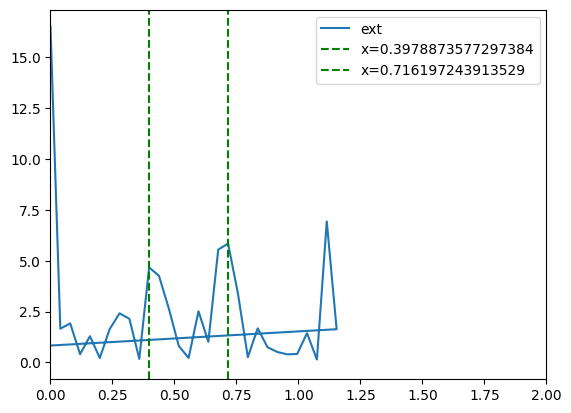

In [16]:
from scipy.signal import find_peaks
k = 1

extended = ramseyBatch1.get_zi(k)[::-1]
extended = extended + ramseyBatch1.get_zi(k)
fft_output_ext = np.fft.fft(extended)

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def extract_two_closest_to_zero(frequencies, peaks):
    """Extract the two peaks closest to zero from the given peaks."""
    # Sort peaks based on their absolute distance to zero
    sorted_peaks = sorted(peaks, key=lambda x: abs(frequencies[x]))
    return sorted_peaks[:2]

# Set the sampling rate based on measurements
sample_rate = measurements / (4 * np.pi)

# Compute the positive frequencies for the FFT output
frequencies_ext = np.fft.fftfreq(2 * len(ramseyBatch1.get_zi(k)), 1 / sample_rate)
positive_indices = np.where(frequencies_ext > 0)
positive_magnitudes = np.abs(fft_output_ext)[positive_indices]

# Find peaks in the positive magnitudes
peaks, _ = find_peaks(positive_magnitudes)

# Get the magnitudes of these peaks
peak_magnitudes = positive_magnitudes[peaks]

# Sort the peaks by their magnitudes in descending order
sorted_peak_indices = np.argsort(peak_magnitudes)[::-1]
n_highest_peaks = sorted_peak_indices[:3]

# Extract two peaks closest to zero
selected_peaks = extract_two_closest_to_zero(frequencies_ext[positive_indices], n_highest_peaks)

# Plot and annotate results
plt.plot(frequencies_ext, np.abs(fft_output_ext), label="ext")

for peak_index in selected_peaks:
    freq_value = frequencies_ext[positive_indices][peaks[peak_index]]
    magnitude_value = peak_magnitudes[peak_index]

    print(f"Frequency: {freq_value*(0.5*np.pi)}, Magnitude: {magnitude_value}")
    plt.axvline(x=freq_value, color='green', linestyle='--', label=f'x={freq_value}')

plt.xlim(0,2)
# Show the plot
plt.legend()
plt.show()

In [12]:
def extract_two_closest_to_zero(frequencies, peaks):
    """Extract the two peaks closest to zero from the given peaks."""
    # Sort peaks based on their absolute distance to zero
    sorted_peaks = sorted(peaks, key=lambda x: abs(frequencies[x]))
    return sorted_peaks[:2]

sample_rate = measurements / (10 * np.pi)

peak_pairs  = []
for i in range(n):
    extended = ramseyBatch1.get_zi(i)[::-1]
    extended = extended + ramseyBatch1.get_zi(i)
    fft_output_ext = np.fft.fft(extended)
    frequencies_ext = np.fft.fftfreq(2 * len(ramseyBatch1.get_zi(i)), 1 / sample_rate)

    positive_indices = np.where(frequencies_ext > 0)
    positive_magnitudes = np.abs(fft_output_ext)[positive_indices]

    # Find peaks in the positive magnitudes
    peaks, _ = find_peaks(positive_magnitudes)

    # Get the magnitudes of these peaks
    peak_magnitudes = positive_magnitudes[peaks]

    # Sort the peaks by their magnitudes in descending order
    sorted_peak_indices = np.argsort(peak_magnitudes)[::-1]
    n_highest_peaks = sorted_peak_indices[:3]

    # Extract two peaks closest to zero
    selected_peaks = extract_two_closest_to_zero(frequencies_ext[positive_indices], n_highest_peaks)

    freq = []
    for peak_index in selected_peaks:
        freq.append(frequencies_ext[positive_indices][peaks[peak_index]]*(0.5*np.pi))

    peak_pairs.append((freq[0],freq[1]))
print(peak_pairs)

def find_ordered_js(peak_pairs):
    ordered_js = []
    n = len(peak_pairs)

    # Start with the first qubit
    current_peaks = list(peak_pairs[0])

    for i in range(n):
        next_peaks = peak_pairs[(i + 1) % n]

        # Find the closest peak between the two sets
        distances = (min([abs(current_peaks[0] - p) for p in next_peaks]), min([abs(current_peaks[1] - p) for p in next_peaks]))

        if(distances[0] < distances[1]):
            ordered_js.append(current_peaks[0])
        else:
            ordered_js.append(current_peaks[1])

        current_peaks = next_peaks

    return ordered_js

ordered_js = find_ordered_js(peak_pairs)
print(ordered_js)
#[1.2994418279088895, 0.7049372527771903, 0.8584715400487917, 1.170570573845352]


[(1.175, 1.2999999999999998), (0.7, 1.2999999999999998), (0.7, 0.85), (0.85, 1.175)]
[1.2999999999999998, 0.7, 0.85, 1.175]


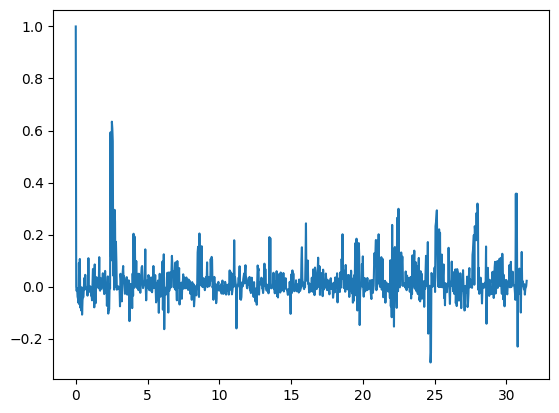

In [6]:
plt.plot(delay, ramseyBatch1.get_zi(0), label='Simulation')